Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


(0.0, 1.0, 0.0, 1.0)

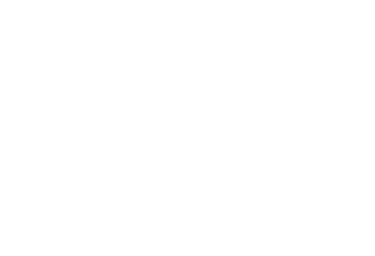

In [1]:
import networkx as nx
import plotly.plotly as py
from plotly.graph_objs import * 
import matplotlib.pyplot as plt
import operator
import scipy as sp

%pylab inline
plt.show()
plt.axis('off')

In [384]:
import sqlite3
conn = sqlite3.connect('data/bifurcation/dataset.sqlite3')
c = conn.cursor()

def get_useful_cursor(table):
    c.execute('SELECT * FROM {}'.format(table))
    columns = [col[0] for col in c.description]
    for raw in c.fetchall():
        yield dict(zip(columns, raw))

tables = [t[0] for t in c.execute("SELECT name FROM sqlite_master WHERE type='table';")]
assert tables == ['entity', 'question', 'ask']
        
questions = {}

for row in get_useful_cursor('ask'):
    question = row['question']

    if question not in questions:
        questions[question] = {'graph': nx.DiGraph(), 'initiators': []}
        
    start = row.get('time_start')
    end = row.get('time_ack')
    answer = row.get('answer')
    
    questions[question]['graph'].add_edge(str(row['entity_from']), 
                                          str(row['entity_to']), 
                                          start=start, 
                                          end=end, 
                                          answer=answer)

chain_length_summary = {}    
    
count = 0
for q in questions:
    count += 1
#     if count != 2:
#         continue
    g = questions[q]['graph']
    #   nx.draw_graphviz(g, with_labels=True)
    #nx.draw_spring(g, with_labels=True)
    l = len(g.edges()) + 1
    if l not in chain_length_summary:
        chain_length_summary[l] = 0

    chain_length_summary[l] += 1
#     print g.edges()
#     print g.nodes()
    for n in g.nodes_iter():
        if g.predecessors(n) == []:
            questions[q]['initiator'] = n
            break
    
print "Chain Length Summary"
sorted(chain_length_summary.items(), key=operator.itemgetter(0))
for k, v in chain_length_summary.items():
    print k, v
    

Chain Length Summary
3 16
4 1
5 10
6 2
7 9
8 6
9 2
11 2
12 1
14 1


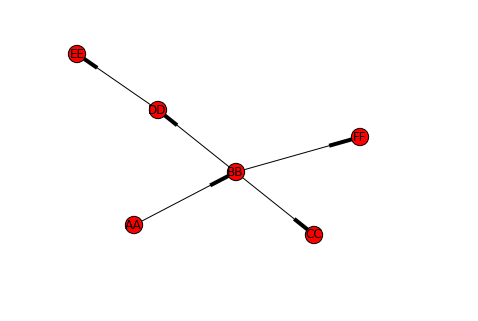

In [96]:
G = nx.DiGraph()

G.add_edge('AA', 'BB', start=10, end=20)
G.add_edge('BB', 'CC', start=30, end=50)
G.add_edge('BB', 'DD', start=25, end=100, answer=120)
G.add_edge('DD', 'EE', start=130, end=140, answer=150)
G.add_edge('BB', 'FF', start=35, end=None)
        
nx.draw_graphviz(G, with_labels=True)

In [240]:
def build_ack_table(G, verbose=False):
    table = {}
    for u, v, edata in G.edges(data=True):
        start = edata.get('start')
        end = edata.get('end')
        if end is None:
            if verbose is True:
                print "{node} didn't acknowledge".format(node=v)
            continue
        if verbose is True:            
            print "{node} acknowledged in {time} minutes".format(node=v, time=end-start)
        table[v] = {'ACK': end - start, 't': end}
    return table


In [241]:
def build_route_table(G, ack_table, verbose=False):
    table = {}
    for u, v, edata in G.edges(data=True):
        start = edata.get('start')
        end = edata.get('end')
        
        if u not in table:
            table[u] = []
            
        ack = ack_table.get(u)
        if ack is None:
            continue
        
        t = ack.get('t')
                    
        table[u].append(start - t)

    return table


In [252]:
def build_raw_score_table(G, initiator, ack_table, route_table, verbose=False):
    #
    # ACK + max(ROUTE1, ROUTE2, ROUTE3)
    #
    table = {}    
    
    for u, v, edata in G.edges(data=True):
        if u in table:
            continue
            
        a = ack_table.get(u)
        if a is None:
            ack = 0
        else:
            ack = a.get('ACK')
        route = route_table.get(u)
        if any(route):
            value = ack + max(route)
            table[u] = value      
            if verbose is True:
                print "{node} = {ack} + max({route}) = {value}".format(node=u, ack=ack, route=route, value=value)

        
    for node, ack in ack_table.items():
        if node in table:
            continue
            
        table[node] = ack.get('ACK')

    table[initiator] = 0
    return table
        

In [330]:
import numpy
def median(lst):
    return numpy.median(numpy.array(lst))


def network_responsive_median_over_two(g, initiator, node, 
                                       ack_table=None, 
                                       route_table=None, 
                                       raw_score_table=None,
                                       table=None,
                                       verbose=False):
    
    if ack_table is None:
        ack_table = build_ack_table(g, verbose)
        if verbose is True:
            print "== ACK TABLE =="
            print ack_table

    if route_table is None:
        route_table = build_route_table(g, ack_table, verbose)
        if verbose is True:
            print "== ROUTING TABLE =="
            print route_table

    if raw_score_table is None:
        raw_score_table = build_raw_score_table(g, initiator, ack_table, route_table, verbose)
        if verbose is True:
            print "== RAW SCORE TABLE =="        
            print raw_score_table

    if table is None:
        table = {}
            
    raw = raw_score_table.get(node)
    if raw is None:
        return 0, table
    
    child_scores = []
    successors = g.successors(node)
    if verbose is True:
        print "{node} has {n} successors {successors}".format(node=node, n=len(successors), successors=successors)
    if len(successors) > 0:

        for n in successors:        
            score, _ = network_responsive_median_over_two(g, initiator, n, 
                                                          ack_table=ack_table, 
                                                          route_table=route_table, 
                                                          raw_score_table=raw_score_table, 
                                                          table=table,
                                                          verbose=verbose)

            child_scores.append(score)
        table[node] = raw + median(child_scores) / 2
        return table[node], table

    table[node] = raw
    return table[node], table
        
print network_responsive_median_over_two(G, 'AA', 'AA', verbose=False)
assert network_responsive_median_over_two(G, 'AA', 'AA', verbose=False) == (17.5, {'CC': 20, 'EE': 10, 'DD': 110.0, 'AA': 17.5, 'BB': 35.0})

(17.5, {'CC': 20, 'EE': 10, 'DD': 110.0, 'AA': 17.5, 'BB': 35.0})


In [353]:
def build_history_table(questions):
    table = {}
    for uid, data in questions.items():
        initiator = data['initiator']
        
        _, network_values = network_responsive_median_over_two(data['graph'], initiator, initiator, verbose=False)

        for entity, value in network_values.items():
            if entity not in table:
                table[entity] = []
                
            table[entity].append(value)
    return table

print build_history_table(questions)

{'24': [0.03552505886399615, 0.0971805416239988, 0.3840311931829987, 0.4368483937879972, 0.5966907895282998, 0.41675636114699977], '25': [5.424849924179995, 3.2971605232800005, 8.314194494592002, 2.803572938704799, 23.646982942943, 12.0076726551777, 7.5890004387046, 5.03431465377], '26': [0.8669386577360001, 3.0748863367849992, 2.3986946300899987], '27': [6.6318874492260065, 38.39412528331751, 3.5625866665291, 2.1527718684900066, 9.535054007977998], '20': [17.114829900781, 15.776860528178, 20.806326848459999, 29.365815947517, 9.8509417660411494, 20.629148674743, 29.402013887075999], '21': [8.015406169262, 1.5737664509489946, 3.1064825200440005], '22': [0.4432320303903001, 1.8172049127439998, 1.6060823333209981], '23': [0.24069552262800187, 0.020618077866100037, 0.3128886280160046], '28': [2.591799608606003, 0.42377311603999956, 0.6538863945899998, 3.398798452895008, 1.8121531172000118, 1.5523463684519996, 1.0348094153349905], '29': [1.2805846327513, 1.5842785859569997, 3.51393233144699

In [354]:
def reduce_history(table):
    reduced = {}
    for uid, history in table.items():
        reduced[uid] = mean(history)
    return reduced
    
print reduce_history(build_history_table(questions))
    

{'24': 0.32783872302238176, '25': 8.5147185714190119, '26': 2.1135065415369994, '27': 12.055285055108124, '20': 20.42084822182802, '21': 4.2318850467516649, '22': 1.2888397588184326, '23': 0.19140074283670216, '28': 1.6382237818740017, '29': 3.5637094657412591, '1': 21.694944161717405, '3': 26.801821482591308, '2': 11.805705389378726, '5': 25.594774480221414, '4': 28.095738830348846, '7': 15.892590109996428, '6': 11.255500307004667, '9': 12.247609176947554, '8': 10.494331273383143, '11': 10.947661102608325, '10': 17.901767389870358, '13': 83.594329996744634, '12': 13.012920873473561, '15': 77.414567665846249, '14': 28.1152234947265, '17': 40.33278978956821, '16': 29.286234312298074, '19': 77.573423372412748, '18': 40.440670517022198, '30': 6.4265305458896664}


In [385]:

def rank(reduced_history_table, pretty=False):

    r = sorted(reduced_history_table.items(), key=operator.itemgetter(1))
    if pretty is False:
        return r
    
    for x in xrange(1, len(r)):
        print x, r[x]
        
print rank(reduce_history(build_history_table(questions)), pretty=True)
    

1 ('28', 0.46246441836833502)
2 ('22', 0.9526285781016085)
3 ('21', 1.0281640766736)
4 ('30', 1.1894088668875233)
5 ('23', 1.5279909899844466)
6 ('24', 2.3638771413977824)
7 ('26', 6.7644165907615674)
8 ('17', 7.5369450174567749)
9 ('29', 8.8647144358956229)
10 ('9', 10.884374425938791)
11 ('6', 12.508148921906244)
12 ('25', 13.970325225509029)
13 ('2', 14.004478299887822)
14 ('1', 14.634470305087945)
15 ('5', 16.17890269616327)
16 ('16', 17.229102592499103)
17 ('7', 18.44157096022337)
18 ('19', 20.67004170174544)
19 ('3', 21.309704636033064)
20 ('10', 22.911293090328169)
21 ('13', 23.122300269988518)
22 ('18', 27.639013838966726)
23 ('20', 29.169026651212789)
24 ('4', 30.806470426290581)
25 ('12', 45.619924831082933)
26 ('15', 73.520956917235765)
27 ('8', 83.362684301982227)
28 ('11', 96.636722857899414)
29 ('14', 134.79716158588286)
None


3


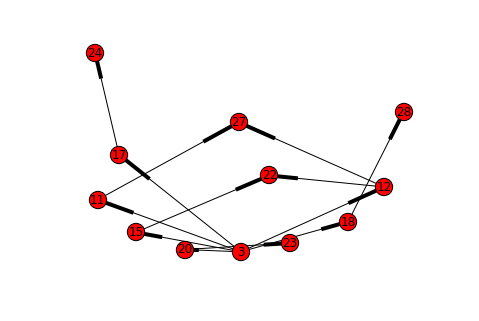

In [399]:
# to do
# 1. utility to print all questions with a given node in for validation
#


def get_data_for_entity(element, print_graph=False):
    ack_times = []
    route_times = []

    for uid, data in questions.items():
        g = data['graph']    
        i = data['initiator']    
        if element in g.nodes():
            a = build_ack_table(g)
            r = build_route_table(g, a)
            ack_times.append(a.get(element, {}).get('ACK'))
            route_times.append(r.get(element))
            if print_graph is True:
                nx.draw_graphviz(g, with_labels=True)
                break
                
    print "ACK times:", ack_times
    print "Routing times:", route_times
    print "-" * 20
    

#get_data_for_entity('9', True)    
    
#for uid, score in rank(reduce_history(build_history_table(questions))):    
#    print "Data for {uid} score:{score}".format(uid=uid, score=score)
#    get_data_for_entity(uid)
    
def print_question(n):
    print questions[n]['initiator']
    nx.draw_graphviz(questions[n]['graph'], with_labels=True)
    

print_question(1)    

In [377]:
for row in get_useful_cursor('ask'):
    if 5 in (row['entity_from'], row['entity_to']):
        print row

{'time_start': 0, 'entity_from': 5, 'question': 2, 'time_ack': 15.218512733211, 'entity_to': 13, 'time_answer': None, 'id': 3}
{'time_start': 0, 'entity_from': 5, 'question': 3, 'time_ack': 0.060117422716512, 'entity_to': 17, 'time_answer': None, 'id': 5}
{'time_start': 0, 'entity_from': 5, 'question': 7, 'time_ack': 0.056955750616366, 'entity_to': 20, 'time_answer': None, 'id': 13}
{'time_start': 0, 'entity_from': 5, 'question': 18, 'time_ack': 6.2229051321983, 'entity_to': 17, 'time_answer': None, 'id': 35}
{'time_start': 0, 'entity_from': 5, 'question': 25, 'time_ack': 13.64599606334, 'entity_to': 19, 'time_answer': None, 'id': 49}
{'time_start': 0, 'entity_from': 5, 'question': 29, 'time_ack': 1.1300773013969, 'entity_to': 20, 'time_answer': None, 'id': 57}


In [388]:
mean


<function numpy.core.fromnumeric.mean>

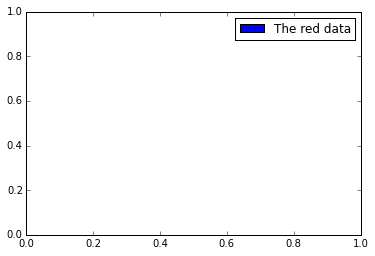

In [401]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='The red data')
plt.legend(handles=[red_patch])

plt.show()